In [ ]:
# colab ÌïúÍ∏Ä Ìè∞Ìä∏Î¨∏Ï†ú
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# tokenizer
!pip install konlpy

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
import pickle

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# simbolic link
!ln -s /content/gdrive/My\ Drive/chat_bot/ReviewReactionBot /chat_bot
!ls /chat_bot

Mounted at /content/gdrive
checkpoints	preprocessing.ipynb  Seq2Seq_model.py
data		preprocessing.py     Seq2Seq_Transformer.ipynb
df_save.pkl	__pycache__	     small_transformer.png
lightning_logs	README.md	     soynlp_word_extractor.pkl
model_chp	requirements.txt     train_koGPT2.py
preprocessing	ReviewReactionBot    visualize.ipynb


In [4]:
class MyConfig(dict):
  def __getattr__(self, name): return self[name]
  def __setattr__(self, name, value): self[name] = value

configs = MyConfig({
    'path_drive' : Path('/chat_bot')
})
configs.datalist = [f for f in (configs.path_drive / 'data').glob('*') if 'pkl' in str(f)]



In [5]:
ff = ( pickle.load(open(f, 'rb')) for f in configs.datalist )
df = pd.concat(ff, axis=0, ignore_index=True)
df.tail()

restaurant  ... location
646071    Í∞àÎπÑ&Ìï¥Î¨ºÎÇòÎùº  ...  Í∞ïÎÇ®Íµ¨ Ïã†ÏÇ¨Îèô
646072    Í∞àÎπÑ&Ìï¥Î¨ºÎÇòÎùº  ...  Í∞ïÎÇ®Íµ¨ Ïã†ÏÇ¨Îèô
646073    Í∞àÎπÑ&Ìï¥Î¨ºÎÇòÎùº  ...  Í∞ïÎÇ®Íµ¨ Ïã†ÏÇ¨Îèô
646074    Í∞àÎπÑ&Ìï¥Î¨ºÎÇòÎùº  ...  Í∞ïÎÇ®Íµ¨ Ïã†ÏÇ¨Îèô
646075       Î∞òÏõîÏãùÎãπ  ...  Í∞ïÎÇ®Íµ¨ Ïã†ÏÇ¨Îèô

[5 rows x 8 columns]

In [6]:
# drop null review
df = df[~( ( df['review'].isnull() ) |  ( df['answer'].isnull() ) )]

## Î≥ÑÏ†êÎ∂ÑÌè¨
- total Í∞íÏùÄ 5Ï†êÎßå ÏàòÏßëÎêòÏóàÏùå(Îç∞Ïù¥ÌÑ∞ Ïò§Î•ò)
- `['taste','quantity','delivery']` Ïùò ÌèâÍ∑† Ï†êÏàòÎ•º ÏÇ¨Ïö©
- ÎåÄÎ∂ÄÎ∂ÑÏùò Î≥ÑÏ†êÏù¥ 4.3Ï†ê Ïù¥ÏÉÅÏóê ÏúÑÏπò

In [7]:
df[['taste','quantity','delivery']] = df[['taste','quantity','delivery']].apply(pd.to_numeric)
df['star_avg'] = df.loc[:,['taste','quantity','delivery']].mean(axis=1)
df['star_avg'] = df['star_avg'].apply(lambda x: round(x,1))
# Î≥ÑÏ†ê ÎπÑÏú®
df.star_avg.value_counts() / len(df)

5.0    0.707783
4.7    0.090460
4.3    0.059212
4.0    0.053668
3.7    0.025614
3.0    0.015159
3.3    0.013028
1.0    0.006906
2.3    0.005884
2.7    0.005738
2.0    0.003500
1.7    0.002078
1.3    0.001069
4.5    0.000180
3.5    0.000020
2.5    0.000018
1.5    0.000005
Name: star_avg, dtype: float64

In [96]:
df.star_avg.mean()

4.710981188454977

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


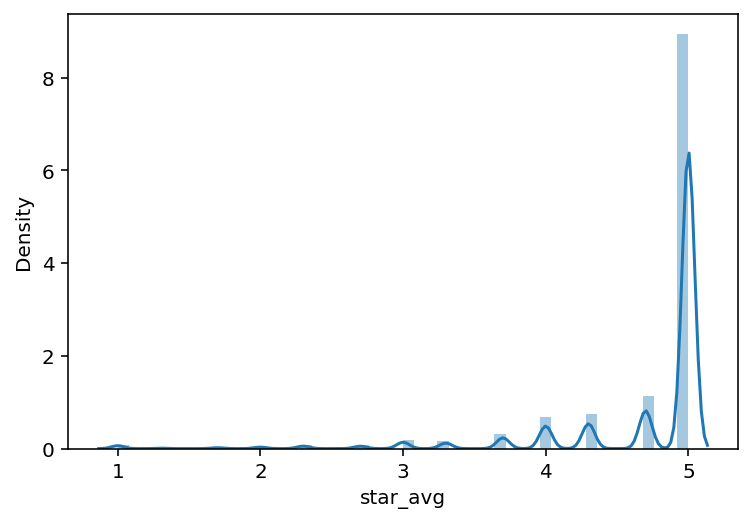

In [8]:
# simple visualize
sns.distplot(df.star_avg)

# ÎπàÎèÑÍ∏∞Î∞ò Ï†ÑÏ≤òÎ¶¨
- Ï¥ù 1523Í∞ú Îß§Ïû•Ïùò Îç∞Ïù¥ÌÑ∞
- Í∞ÄÏû• Î¶¨Î∑∞Í∞Ä ÎßéÏùÄ Îß§Ïû•ÏùÄ 10883Í∞ú Î¶¨Î∑∞
- Í∞ÄÏû• Ï†ÅÏùÄ Îß§Ïû•ÏùÄ 1Í∞ú
- ÌèâÍ∑† Î¶¨Î∑∞ ÏàòÎäî 401Í∞ú

In [9]:
df['unique_word'] = df['answer'].apply(lambda x: str(x).split())
df['count_unique_word'] = df['unique_word'].apply(lambda x: len(x))

df['unique_name'] = df.restaurant+'-'+df.location
# Îß§Ïû•-ÏúÑÏπò Ï°∞Ìï©ÏúºÎ°ú unique - total Îß§Ïû• Ïàò
print(f'Unique Îß§Ïû• Ïàò : {len(set(df.unique_name))}')

n_review_per_rest = df.groupby('unique_name')['answer'].count()

print(f'Îß§Ïû•Î≥Ñ ÌèâÍ∑† Î¶¨Î∑∞ Ïàò - {n_review_per_rest.values.mean()}')
print(f'Í∞ÄÏû• Î¶¨Î∑∞Í∞Ä ÎßéÏùÄ Îß§Ïû• Î¶¨Î∑∞ Ïàò - {n_review_per_rest.values.max()}')
print(f'Í∞ÄÏû• Î¶¨Î∑∞Í∞Ä Ï†ÅÏùÄ Îß§Ïû• Î¶¨Î∑∞ Ïàò - {n_review_per_rest.values.min()}')

Unique Îß§Ïû• Ïàò : 1523
Îß§Ïû•Î≥Ñ ÌèâÍ∑† Î¶¨Î∑∞ Ïàò - 401.61851608667104
Í∞ÄÏû• Î¶¨Î∑∞Í∞Ä ÎßéÏùÄ Îß§Ïû• Î¶¨Î∑∞ Ïàò - 10883
Í∞ÄÏû• Î¶¨Î∑∞Í∞Ä Ï†ÅÏùÄ Îß§Ïû• Î¶¨Î∑∞ Ïàò - 1


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


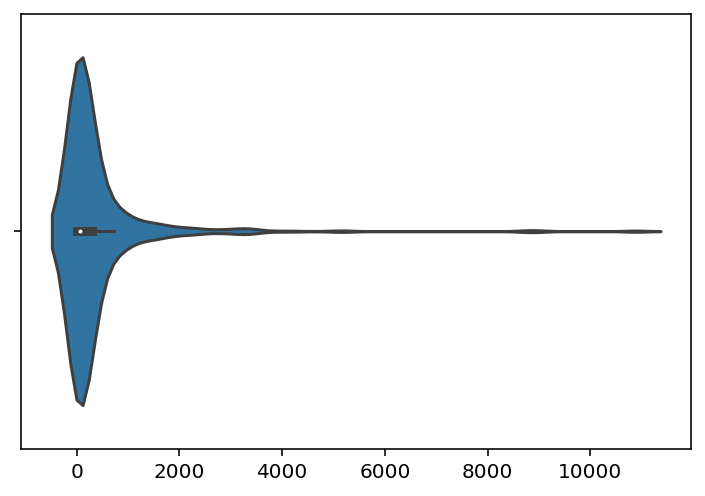

In [10]:
sns.violinplot(n_review_per_rest.values)

In [11]:
def counters(df):
  words = np.hstack(df.unique_word.values)
  unique_words = len(set(words))

  n_reviews = df.shape[0]
  return unique_words, n_reviews

def get_values(string, unique_restaurant_dict):
  return pd.Series(unique_restaurant_dict[f'{string}'])

# unique Îß§Ïû• Ïù¥Î¶ÑÏùÑ keyÎ°ú Í∞ñÎäî dictionary
unique_restaurant_dict = dict.fromkeys(set(df.unique_name),0)
len(unique_restaurant_dict)

1523

In [12]:
# (Î¶¨Î∑∞Ïóê ÏÇ¨Ïö©Îêú Unique Îã®Ïñ¥ Ïàò) and (Î¶¨Î∑∞ Ïàò) per Îß§Ïû• Ïª¨Îüº ÏÉùÏÑ±
for k in unique_restaurant_dict.keys():
  # print(k)
  unique_words, n_reviews = counters(df[df.unique_name == k])
  unique_restaurant_dict[f'{k}'] = {'unique_vector': unique_words, 'n_reviews': n_reviews}


In [13]:
df_counter = df['unique_name'].apply(lambda x: get_values(x, unique_restaurant_dict))
df = pd.concat([df, df_counter], axis=1)
df.head()

restaurant  ... n_reviews
12   Î∂ÄÏñ¥ÏπòÌÇ®-ÏÑ∏Í≥°Ï†ê  ...      1092
13   Î∂ÄÏñ¥ÏπòÌÇ®-ÏÑ∏Í≥°Ï†ê  ...      1092
14   Î∂ÄÏñ¥ÏπòÌÇ®-ÏÑ∏Í≥°Ï†ê  ...      1092
15   Î∂ÄÏñ¥ÏπòÌÇ®-ÏÑ∏Í≥°Ï†ê  ...      1092
16   Î∂ÄÏñ¥ÏπòÌÇ®-ÏÑ∏Í≥°Ï†ê  ...      1092

[5 rows x 14 columns]

### - Îß§Ïû•Î≥ÑÎ°ú Î¶¨Î∑∞Ïóê ÏÇ¨Ïö©Îêú Unique Îã®Ïñ¥ ÏàòÎ•º Í∏∞Ï§ÄÏúºÎ°ú Îß§ÌÅ¨Î°ú Ï≤òÎüº ÏûëÏÑ±Îêú Î¶¨Î∑∞Î•º Cutoff

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


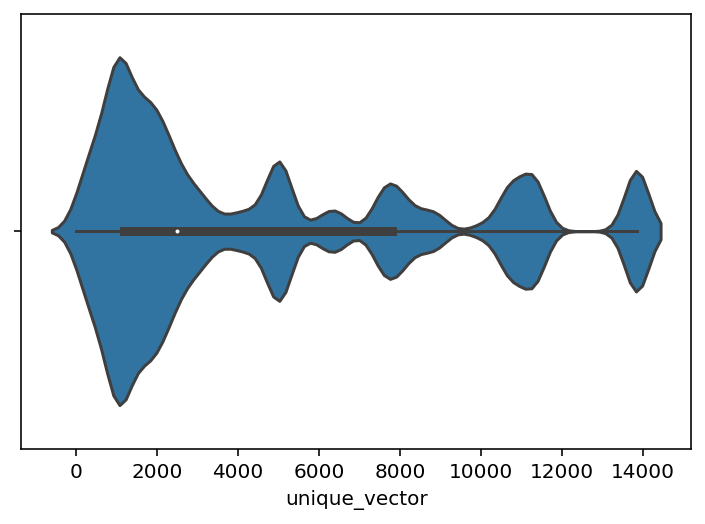

In [14]:
sns.violinplot(df.unique_vector)

In [15]:
# 500 Í∞ú Ïù¥Ìïò Îã®Ïñ¥Îßå ÏÇ¨Ïö©Ìïú Î¶¨Î∑∞ Count
len([f for f in df[df.unique_vector < 500].answer])

34116

In [ ]:
[f for f in df[df.unique_vector < 500].answer]

In [19]:
df_unique = df[df.unique_vector > 500]
print(df.shape, df_unique.shape)

(611665, 14) (577549, 14)


In [20]:
!pip install soynlp

     |‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 416 kB 8.1 MB/s 


In [21]:
df_unique.columns

Index(['restaurant', 'review', 'answer', 'total', 'taste', 'quantity',
       'delivery', 'location', 'star_avg', 'unique_word', 'count_unique_word',
       'unique_name', 'unique_vector', 'n_reviews'],
      dtype='object')

In [81]:
from soynlp import DoublespaceLineCorpus
from soynlp.word import WordExtractor
from soynlp.tokenizer import LTokenizer
from soynlp.normalizer import emoticon_normalize, repeat_normalize

import re

class Regex_pattern():
  def __init__(self):
    self.user_name = re.compile(r'[A-Za-z\\**]+[Îãò]') # user id Ïñ∏Í∏â -> Í≥†Í∞ùÎãò
    self.emoticon_norm = emoticon_normalize
    self.repeat_norm = repeat_normalize
    self.punct = re.compile(r'[():><‡πëÀÉÃµ·¥óÀÇÃµ/¬≥Àò‚Äª*_#=\-;:„ÖÅ@‚âß‚ñΩ‚â¶o]')

  def __call__(self, string):
    string = self.user_name.sub(r'Í≥†Í∞ùÎãò', string)
    string = self.emoticon_norm(string, num_repeats=3)
    string = self.repeat_norm(string, num_repeats=2)
    string = self.punct.sub('',string)
    return string


regex_pattern = Regex_pattern()



In [82]:
# Ï†ïÍ∑úÌëúÌòÑÏãù filter tester
test = 'su**Îãò *ÏÜåÏ§ëÌïú Î¶¨Î∑∞ Í∞êÏÇ¨Ìï©ÎãàÎã§ÏïÑÏïÑÏïÑÏïÑÏïÑÏïÑÏïÑÏïÑÏïÑ! „Öã„Öã„Öã„Öã„Öã„Öã„ÖãÌÅê„Ö†„Ö†„Ö†„Ö†„Ö†„Ö†„Ö† \
Îã§ÏùåÏóêÎèÑ ÎßõÏûàÎäî Ìïú ÎÅº ÎìúÎ¶¥ Ïàò ÏûàÍ≤å Ìï≠ÏÉÅ ÏµúÏÑ†ÏùÑ Îã§ÌïòÍ≤†ÏäµÎãàÎã§!‚Äª##=--;:„ÖÅ@‚âß‚ñΩ‚â¶o \
Í∞êÏÇ¨Ìï©ÎãàÎã§ >_< üö® (‡πëÀÉÃµ·¥óÀÇÃµ)/ üö® üëâ 1Ïù∏Î∂ÑÎßåÏ£ºÎ¨∏Ìï¥ÎèÑ Îäò ÎßõÏûàÍ≤åÎßåÎìúÎäî Ï†ïÍ≤®Ïö¥ ÎèôÎÑ§ÎßõÏßëÏù¥ ÎêòÎèÑÎ°ù ÎÖ∏Î†•ÌïòÍ≤†ÏäµÎãàÎã§~! \
ÏöîÏ¶òÎÇ†Ïî®Í∞Ä ÎßéÏù¥Ï∂îÏõåÏ°åÏäµÎãàÎã§ Í∞êÍ∏∞Ï°∞Ïã¨ÌïòÏãúÍµ¨ Ïñ∏Ï†úÎÇò üî•Îî∞ÎúªÌïúüî•ÌïúÎÅºÏãùÏÇ¨ ÎåÄÏ†ëÏùÑÏúÑÌï¥ Ïò§ÎäòÎèÑ Ïó¥Ïã¨ÌûàÏùºÌïòÎäî ÌòºÎ∞•ÎåÄÏôïÏù¥ ÎêòÍ≤†ÏäµÎãàÎã§ \
Ïò§ÎäòÎèÑ Ïù¥Ïö©Ìï¥Ï£ºÏã† Í≥†Í∞ùÎãòÏóêÍ≤å Î¨¥ÌïúÌïú Í∞êÏÇ¨Î•º ÌëúÌï©ÎãàÎã§ :) Îäò ÏµúÏÑ†ÏùÑÎã§ÌïòÎäî Ï†ïÍ≤®Ïö¥ ÌïúÏãùÏßëÏù¥ ÎêòÍ≤†ÏäµÎãàÎã§~! ‚ù§ üåü ÌòºÎ∞•ÎåÄÏôï üåü'

regex_pattern(test)

'Í≥†Í∞ùÎãò ÏÜåÏ§ëÌïú Î¶¨Î∑∞ Í∞êÏÇ¨Ìï©ÎãàÎã§ÏïÑÏïÑÏïÑ! „Öã„Öã„Öã„Ö†„Ö†„Ö† Îã§ÏùåÏóêÎèÑ ÎßõÏûàÎäî Ìïú ÎÅº ÎìúÎ¶¥ Ïàò ÏûàÍ≤å Ìï≠ÏÉÅ ÏµúÏÑ†ÏùÑ Îã§ÌïòÍ≤†ÏäµÎãàÎã§! Í∞êÏÇ¨Ìï©ÎãàÎã§  üö®  üö® üëâ 1Ïù∏Î∂ÑÎßåÏ£ºÎ¨∏Ìï¥ÎèÑ Îäò ÎßõÏûàÍ≤åÎßåÎìúÎäî Ï†ïÍ≤®Ïö¥ ÎèôÎÑ§ÎßõÏßëÏù¥ ÎêòÎèÑÎ°ù ÎÖ∏Î†•ÌïòÍ≤†ÏäµÎãàÎã§~! ÏöîÏ¶òÎÇ†Ïî®Í∞Ä ÎßéÏù¥Ï∂îÏõåÏ°åÏäµÎãàÎã§ Í∞êÍ∏∞Ï°∞Ïã¨ÌïòÏãúÍµ¨ Ïñ∏Ï†úÎÇò üî•Îî∞ÎúªÌïúüî•ÌïúÎÅºÏãùÏÇ¨ ÎåÄÏ†ëÏùÑÏúÑÌï¥ Ïò§ÎäòÎèÑ Ïó¥Ïã¨ÌûàÏùºÌïòÎäî ÌòºÎ∞•ÎåÄÏôïÏù¥ ÎêòÍ≤†ÏäµÎãàÎã§ Ïò§ÎäòÎèÑ Ïù¥Ïö©Ìï¥Ï£ºÏã† Í≥†Í∞ùÎãòÏóêÍ≤å Î¨¥ÌïúÌïú Í∞êÏÇ¨Î•º ÌëúÌï©ÎãàÎã§  Îäò ÏµúÏÑ†ÏùÑÎã§ÌïòÎäî Ï†ïÍ≤®Ïö¥ ÌïúÏãùÏßëÏù¥ ÎêòÍ≤†ÏäµÎãàÎã§~! ‚ù§ üåü ÌòºÎ∞•ÎåÄÏôï üåü'

In [28]:
df_unique['name'] = df_unique['unique_name'].apply(lambda x: ' '.join(str(x).split('-')) )
df_unique['answer_clean'] = df_unique['answer'].apply(lambda x: regex_pattern(x))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# training soynlp word_extractor
sentences = list(df_unique.answer_clean) + list(df_unique.review) + list(set(df_unique.name))

word_extractor = WordExtractor(min_frequency=100,
    min_cohesion_forward=0.05, 
    min_right_branching_entropy=0.0
)
word_extractor.train(sentences) # list of str or like
words = word_extractor.extract()

# save word_score
with open(configs.path_drive / 'soynlp_word_extractor.pkl','wb') as f:
  pickle.dump(words, f)

training was done. used memory 6.545 Gb
all cohesion probabilities was computed. # words = 47134
all branching entropies was computed # words = 1111184
all accessor variety was computed # words = 1111184


In [25]:
with open(configs.path_drive / 'soynlp_word_extractor.pkl','rb') as f:
  words = pickle.load(f)

In [26]:
# Ltokenizer with trained cohesion_score
cohesion_score = {word:score.cohesion_forward for word, score in words.items()}
tokenizer = LTokenizer(scores=cohesion_score)

In [30]:
df_unique.head()[:2]

restaurant  ...                                       answer_clean
12   Î∂ÄÏñ¥ÏπòÌÇ®-ÏÑ∏Í≥°Ï†ê  ...  ÎßõÏûàÍ≤å ÎìúÏÖ®Îã§Îãà Ï†ÄÌù¨ÎèÑ Ï†ïÎßê Í∏∞ÏÅ©ÎãàÎã§ „Öé„Öé Îçî ÎßõÏûàÍ≥† Ï†ïÏÑ±Ïä§ÎüΩÍ≤å Ï°∞Î¶¨Ìï†ÌÖåÎãà ÏπòÌÇ® ÏÉù...
13   Î∂ÄÏñ¥ÏπòÌÇ®-ÏÑ∏Í≥°Ï†ê  ...  ÏÜåÏ§ëÌïú ÏÇ¨ÏßÑ Î¶¨Î∑∞ Í∞êÏÇ¨Ìï©ÎãàÎã§ ! ÏïûÏúºÎ°úÎèÑ Îçî ÎßõÏûàÎäî ÏùåÏãùÏúºÎ°ú Ï∞æÏïÑÎµêÍ≤åÏöî ~~ Ï¢ãÏùÄ ...

[2 rows x 16 columns]

In [ ]:
# ÏßÅÏ†ë Tokenizer ÌôïÏù∏ with random sampling
def print_token(df_unique):
  for review,answer,name in zip(df_unique.review,df_unique.answer_clean,df_unique.name):
    name_filter = tokenizer( str(name))
    answer_filter = tokenizer(str(answer))
    re_answer = []
    for a in answer_filter:
      if a in name_filter:
        a = 'Îß§Ïû•'
        re_answer.append(a)
      else :
        re_answer.append(a)

    print(f'{review}\n {name}\n {answer}\n {tokenizer( str(name)) }\n{ tokenizer(str(answer)) }\n{re_answer}\n' )

print_token(df_unique.sample(500))

In [36]:
def tokenizer_with_filter(name,answer):
  
  name = name.replace('-',' ')

  name_filter = tokenizer(str(name))
  answer_filter = tokenizer(str(answer))
  re_answer = []

  for a in answer_filter:
    if a in name_filter:
      a = 'Îß§Ïû•'
      re_answer.append(a)
    else :
      re_answer.append(a)

  return re_answer

In [84]:
df_unique['soy_token_answer'] = ( df_unique[['unique_name','answer_clean']]
                                  .apply(lambda x: tokenizer_with_filter(*x), axis=1) )

df_unique['soy_token_review'] = df_unique['review'].apply(tokenizer) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [86]:
df_unique.head()[:2]

restaurant  ...                                   soy_token_review
12   Î∂ÄÏñ¥ÏπòÌÇ®-ÏÑ∏Í≥°Ï†ê  ...  [ÏôÄ, ÏßÑÏßú, ÎåÄÎ∞ï, ÎßõÏûà, Ïñ¥ÏÑú, ÏïîÏ≤≠, ÎßéÏù¥, Î®πÎã§Í∞Ä, Î¶¨Î∑∞, ÌïòÎäîÍ±∞, ÍπåÎ®πÏñ¥ÏÑú...
13   Î∂ÄÏñ¥ÏπòÌÇ®-ÏÑ∏Í≥°Ï†ê  ...  [ÏπòÌÇ®, Ïù¥, ÏñëÏù¥, Ï†ÅÏñ¥, Î≥¥Ïù¥ÎäîÎç∞, ÏπòÌÇ®, Îç©Ïñ¥Î¶¨, Í∞Ä, ÏóÑÏ≤≠, Ïª§Ïöî!!, Î™©Îçï...

[2 rows x 18 columns]

In [87]:
# save word_score
with open(configs.path_drive / 'df_save.pkl','wb') as f:
  pickle.dump(df_unique, f)

# with open(configs.path_drive / 'df_save.pkl','rb') as f:
#   df_unique = pickle.load(f)

# ÌÜ†ÌÅ∞ EDA

In [88]:
df_unique['n_token_review'] = df_unique['soy_token_review'].apply(lambda x: len(x))
df_unique['n_token_answer'] = df_unique['soy_token_answer'].apply(lambda x: len(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
pd.melt(df_unique[['n_token_review','n_token_answer']], id_vars=['n_token_review','n_token_answer'])

Empty DataFrame
Columns: [n_token_review, n_token_answer, variable, value]
Index: []

In [89]:
df_unique[['n_token_review','n_token_answer','star_avg']].describe()

n_token_review  n_token_answer       star_avg
count   577549.000000   577549.000000  572915.000000
mean        14.144566       38.445753       4.710782
std         13.953964       22.148639       0.636215
min          1.000000        0.000000       1.000000
25%          5.000000       21.000000       4.700000
50%          9.000000       34.000000       5.000000
75%         18.000000       55.000000       5.000000
max        159.000000      105.000000       5.000000

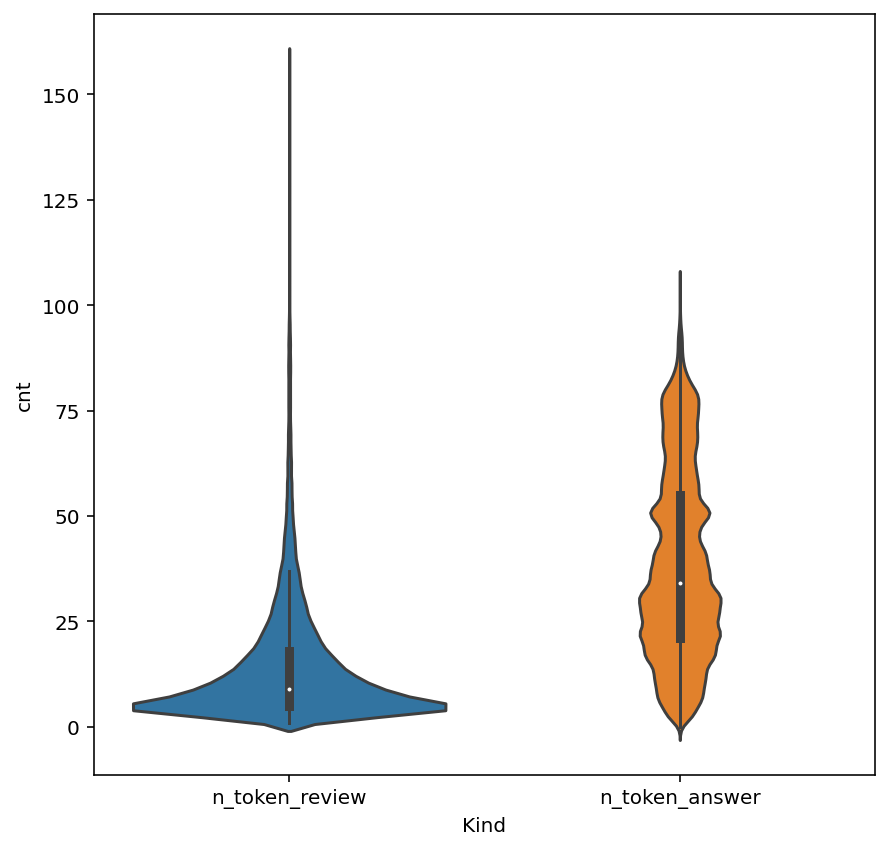

In [94]:
# Visualize token size
df_plt = df_unique[['n_token_review','n_token_answer']].stack().reset_index().rename(columns={'level_1': 'Kind',0:'cnt'})
plt.figure(figsize=(7,7))
sns.violinplot(data=df_plt, x='Kind', y='cnt')

In [95]:
df_unique.star_avg.mean()

4.710781704092879

In [97]:
def binary_score(x):
  if x >=4.7:
    return 'Above avg'
  else : return 'Below avg'
  
df_unique['binary_score'] = df_unique['star_avg'].apply(binary_score)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


[Text(0.5, 0, 'Token Kinds'), Text(0.5, 1.0, 'Score < 4.5')]

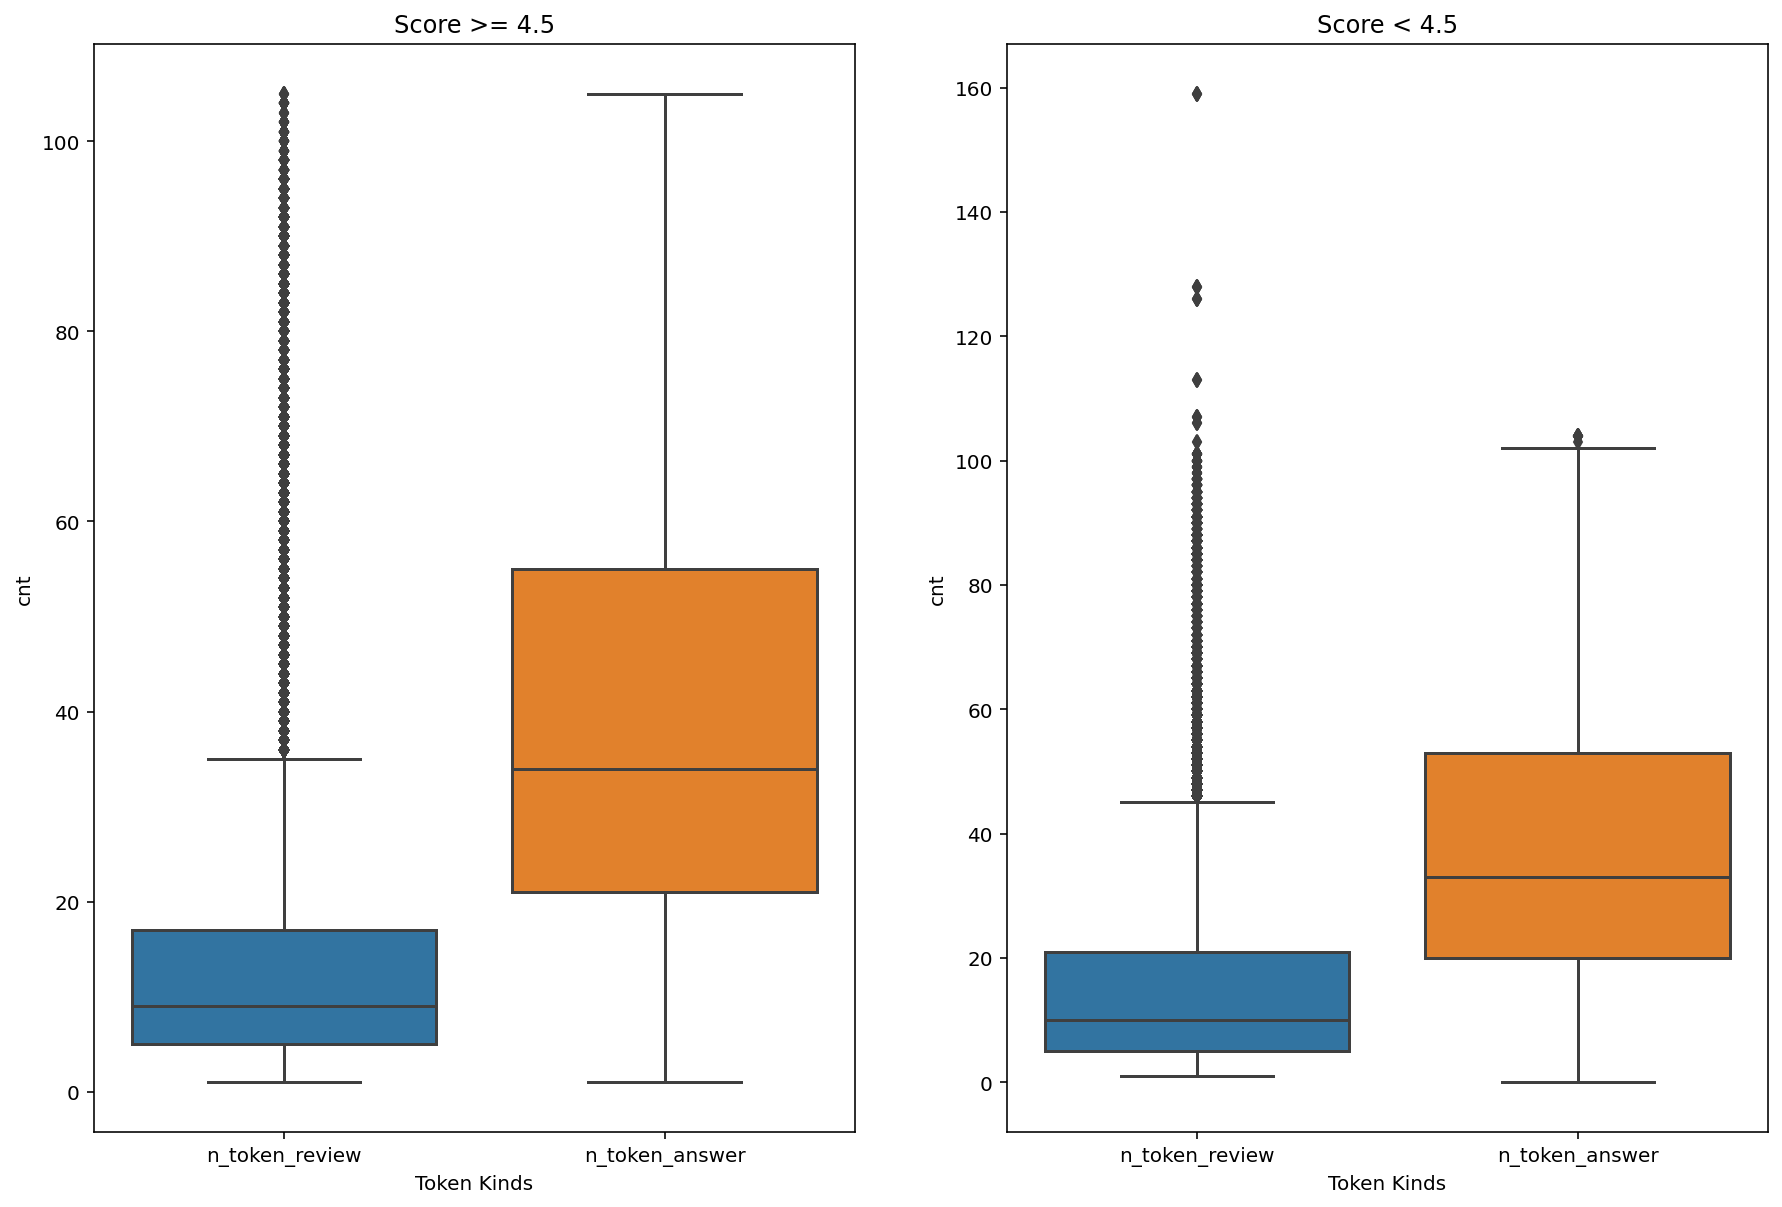

In [98]:
# Visualize token size group by binary_score
fig, ax = plt.subplots(1,2,figsize=(15,10))

sns.boxplot(data=(df_unique
                    .loc[df_unique.binary_score == 'Above avg',['n_token_review','n_token_answer']]
                    .stack()
                    .reset_index()
                    .rename(columns={'level_1': 'Kind',0:'cnt'}))
              , x='Kind', y='cnt', ax=ax[0])  

sns.boxplot(data=(df_unique
                    .loc[df_unique.binary_score == 'Below avg',['n_token_review','n_token_answer']]
                    .stack()
                    .reset_index()
                    .rename(columns={'level_1': 'Kind',0:'cnt'}))
              , x='Kind', y='cnt', ax=ax[1])  

ax[0].set(xlabel='Token Kinds', title="Score >= 4.5")
ax[1].set(xlabel='Token Kinds', title="Score < 4.5")

In [99]:
print(df_unique.loc[df_unique.binary_score == 'Above avg',['n_token_review','n_token_answer']].describe())
print(df_unique.loc[df_unique.binary_score == 'Below avg',['n_token_review','n_token_answer']].describe())

       n_token_review  n_token_answer
count   461561.000000   461561.000000
mean        13.605474       38.606719
std         13.222825       22.051609
min          1.000000        1.000000
25%          5.000000       21.000000
50%          9.000000       34.000000
75%         17.000000       55.000000
max        105.000000      105.000000
       n_token_review  n_token_answer
count   115988.000000   115988.000000
mean        16.289823       37.805204
std         16.371532       22.519318
min          1.000000        0.000000
25%          5.000000       20.000000
50%         10.000000       33.000000
75%         21.000000       53.000000
max        159.000000      104.000000


In [107]:
df_unique.loc[df_unique.binary_score == 'Below avg',['n_token_review','n_token_answer']].describe()

n_token_review  n_token_answer
count   115988.000000   115988.000000
mean        16.289823       37.805204
std         16.371532       22.519318
min          1.000000        0.000000
25%          5.000000       20.000000
50%         10.000000       33.000000
75%         21.000000       53.000000
max        159.000000      104.000000

## Visualize by word cloud

In [100]:
!pip install wordcloud

In [101]:
from collections import Counter
from wordcloud import WordCloud

def word_cnt(df, stopwords):
  words = np.hstack(df_unique[df_unique.binary_score=='Below avg']['soy_token_review'])
  return Counter([w for w in words if w not in stopwords])


In [102]:
stopwords = ['Ïöî', 'ÎèÑ', 'Îäî', 'Îã§', 'Ïùò', 'Í∞Ä', 'Ïù¥', 'ÏùÄ', 'Ìïú', 
             'Ïóê', 'Ìïò', 'Í≥†', 'ÏùÑ', 'Î•º', 'Ïù∏', 'ÎìØ', 'Í≥º', 'ÏôÄ', 
             'ÎÑ§', 'Îì§', 'ÎìØ', 'ÏßÄ', 'ÏûÑ', 'Í≤å','.','....','Ïñ¥Ïöî',
             '..','ÌïòÍ≥†','ÏÑú']

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


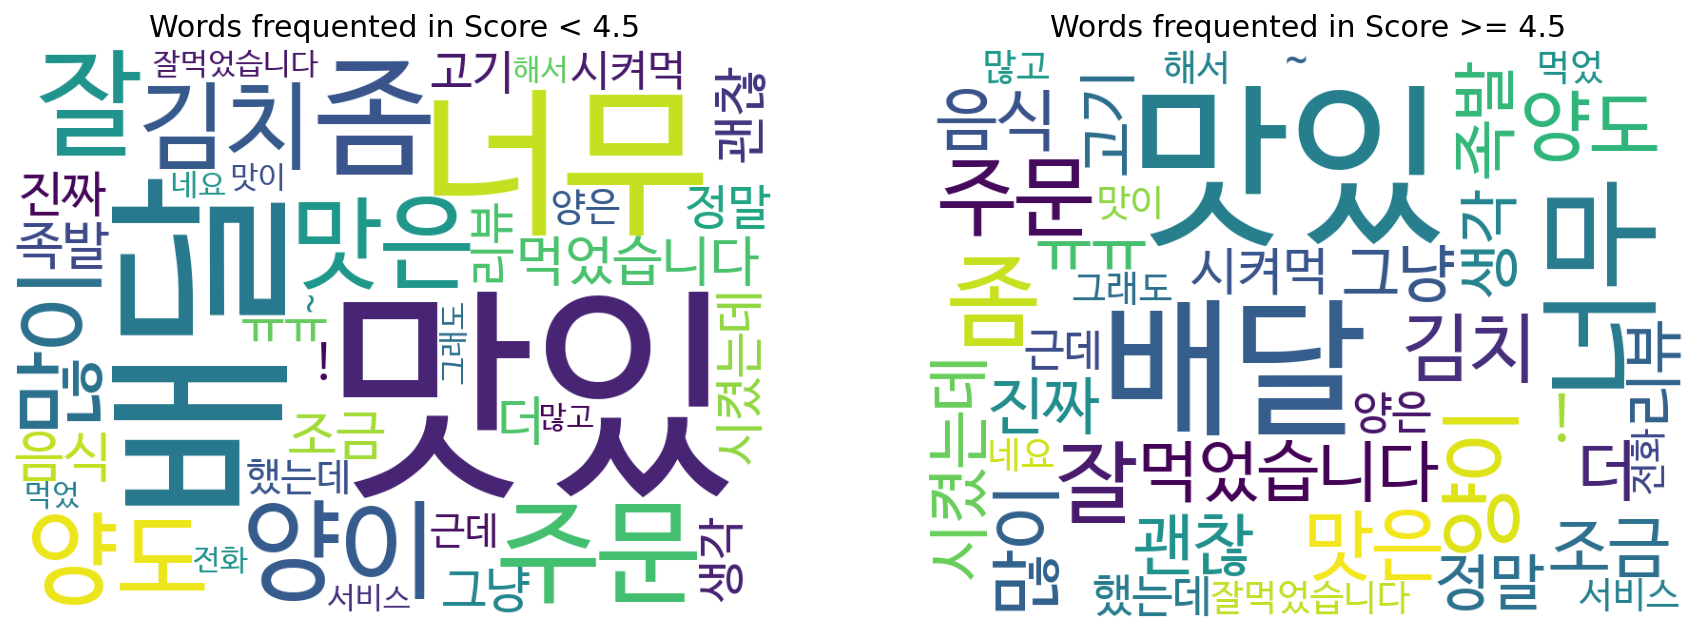

In [103]:
configs.plt_fontsize = 15
configs.n_common_words = 40

plt.figure(figsize=(15,12))
plt.subplot(121)
wc = WordCloud(font_path=fontpath, 
               background_color='white', width=800, height=600)

cloud_data = word_cnt(df_unique[df_unique.binary_score=='Below avg']['soy_token_review']
                      ,stopwords)

cloud = wc.generate_from_frequencies(dict(cloud_data.most_common(configs.n_common_words)))
plt.title("Words frequented in Score < 4.5", fontsize=configs.plt_fontsize)
plt.axis('off')
plt.imshow(cloud)

plt.subplot(122)
wc = WordCloud(font_path=fontpath, 
               background_color='white', width=800, height=600)

cloud_data = word_cnt(df_unique[df_unique.binary_score=='Above avg']['soy_token_review']
                      ,stopwords)

cloud = wc.generate_from_frequencies(dict(cloud_data.most_common(configs.n_common_words)))
plt.title("Words frequented in Score >= 4.5", fontsize=configs.plt_fontsize)
plt.axis('off')
plt.imshow(cloud)

In [ ]:
df_unique['Q'] = df_unique['soy_token_review'].apply(lambda x: ' '.join(x))
df_unique['A'] = df_unique['soy_token_answer'].apply(lambda x: ' '.join(x))
df_unique.head()

In [ ]:
configs

{'datalist': [PosixPath('/chat_bot/data/df_·ÑÄ·Ö°·Üº·ÑÇ·Ö°·Ü∑·ÑÄ·ÖÆ_·Ñâ·Ö¶·ÑÄ·Ö©·Ü®·ÑÉ·Ö©·Üº.pkl'),
  PosixPath('/chat_bot/data/df_·ÑÄ·Ö°·Üº·ÑÇ·Ö°·Ü∑·ÑÄ·ÖÆ_·ÑÄ·Ö¢·Ñë·Ö©·ÑÉ·Ö©·Üº.pkl'),
  PosixPath('/chat_bot/data/df_·ÑÄ·Ö°·Üº·ÑÇ·Ö°·Ü∑·ÑÄ·ÖÆ_·Ñå·Ö°·ÑÄ·Ö©·Ü®·ÑÉ·Ö©·Üº.pkl'),
  PosixPath('/chat_bot/data/df_·Ñâ·Ö©·Üº·Ñë·Ö°·ÑÄ·ÖÆ_·Ñâ·Ö©·Üº·Ñë·Ö°1·ÑÉ·Ö©·Üº.pkl'),
  PosixPath('/chat_bot/data/df_·Ñâ·Ö©·Üº·Ñë·Ö°·ÑÄ·ÖÆ_·Ñâ·Ö©·Üº·Ñë·Ö°2·ÑÉ·Ö©·Üº.pkl'),
  PosixPath('/chat_bot/data/df_·Ñâ·Ö©·Üº·Ñë·Ö°·ÑÄ·ÖÆ_·Ñâ·Ö•·Ü®·Ñé·Ö©·Ü´·ÑÉ·Ö©·Üº.pkl'),
  PosixPath('/chat_bot/data/df_·Ñâ·Ö©·Üº·Ñë·Ö°·ÑÄ·ÖÆ_·ÑÜ·ÖÆ·Ü´·Ñå·Ö•·Üº1·ÑÉ·Ö©·Üº.pkl'),
  PosixPath('/chat_bot/data/df_·Ñâ·Ö©·Üº·Ñë·Ö°·ÑÄ·ÖÆ_·ÑÜ·ÖÆ·Ü´·Ñå·Ö•·Üº2·ÑÉ·Ö©·Üº.pkl'),
  PosixPath('/chat_bot/data/df_·Ñâ·Ö©·Üº·Ñë·Ö°·ÑÄ·ÖÆ_·Ñã·Ö©·ÑÖ·Ö≤·Ü´·ÑÉ·Ö©·Üº.pkl'),
  PosixPath('/chat_bot/data/df_·Ñâ·Ö©·Üº·Ñë·Ö°·ÑÄ·ÖÆ_·Ñã·Ö©·ÑÄ·Ö≥·Ü∑·ÑÉ·Ö©·Üº.pkl'),
  PosixPath('/chat_bot/data/df_·Ñå·Ö©·Üº·ÑÖ·Ö©·ÑÄ·ÖÆ_·Ñâ·Ö°·Ñå·Öµ·Ü®·ÑÉ·Ö©·Üº.pkl'),
  PosixPath('/chat_bot/data/df_·Ñå

In [105]:
df_unique[['Q','A','star_avg']].to_csv(configs.path_drive / 'data' / 'ChatbotData_v2.csv')